In [1]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.assets.Calculate import Calculate
from trade.assets.helpers.loaders import create_object_from_id
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
from trade.helpers.Context import Context
import math
import yfinance as yf
import numpy as np
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
%load_ext autoreload
%autoreload 2


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-29 23:12:03 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [1]:
import sys
from EventDriven.data import HistoricTradeDataHandler


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-31 18:44:27 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [2]:
thetadata_start = '2021-01-01'

In [3]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
_key = 8
with open(f'../input/profitable_weights_{_key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{_key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
tick = 'AMD'
eq_idx = 17
ttrades__ = ttrades__[(ttrades__.Ticker == tick) & (ttrades__.index == eq_idx)]
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
17,126,629,639,94.369141,87.32,-888.191794,-0.074698,2021-07-01,2021-07-16,15,AMD


In [4]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

(AMD    0.160574
 dtype: float64,
 {'AMD': 2})

In [5]:
# from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
# from pandas.tseries.offsets import BDay

# rm = RiskManager(None, None, 1000000)
# rm.OrderPicker.liquidity_threshold = 2
# rm.OrderPicker.lookback = 10
# rm.OrderPicker.data_availability_threshold = 0.15
# date, tick = '2023-07-05', 'AVGO'
# date, tick = '2024-08-13', 'TSM'
# start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
# right = 'C'
# order_settings = {'type': 'spread',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .50,
#    'dte': 210,
#    'moneyness_width': 0.5},
#   #  {'direction': 'short',
#   # 'rel_strike': .60,
#   # 'dte': 270,
#   # 'moneyness_width': 0.35}
# ],
#  'name': 'vertical_spread'}

# order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
# order

In [6]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .85,
   'dte': 365,
   'moneyness_width': 0.10},
   {'direction': 'short',
  'rel_strike': .80,
  'dte': 365,
  'moneyness_width': 0.10}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.portfolio.min_moneyness_threshold = 5
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 90
evb_backtest.portfolio.moneyness_width_factor = .025
evb_backtest.portfolio.dte_reduction_factor = 30
evb_backtest.portfolio.min_acceptable_dte_threshold = 95
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])



signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

Saving to cache from db


1.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [7]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['AMD20220617C115'], 'short': ['AMD20220617C125'], 'trade_id': '&L:AMD20220617C115&S:AMD20220617C125', 'close': 1.9999999999999991}, Date: 2021-07-01, Signal: SignalEvent type:LONG, symbol=AMD, date:2021-07-01 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AMD20210701LONG
Max Contract Price: 2, Cash at Hand: 24.56784911400662
Cash at Hand 24.56784911400662 Close 1.9999999999999991
Processing event: ORDER
Buy Order Position: {'long': ['AMD20220617C115'], 'short': ['AMD20220617C125'], 'trade_id': '&L:AMD20220617C115&S:AMD20220617C125', 'close': 1.9999999999999991} Price: 2.0764538773598953 Quantity: 11 Datetime: 2021-07-01 00:00:00
Processing event: FILL
Event queue is empty, processed 4 event(s)
Processing event: MARKET
Event queue is empty, processed 1 event(s)
Processing event: MARKET
Event queue is empty, processed 1 event(s)
Processing event: MARKET
Event queue is empty, processed 1 e

## ***VISUALIZE TEST RESULTS***

In [8]:
##Transaction details

pd.set_option('display.max_rows', 100)
print(_key)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol==tick]

8


,signal_id,datetime,symbol,direction,cash_before,cash_after
0,AMD20210701LONG,2021-07-01,AMD,BUY,2729.761013,431.361748
1,AMD20210701LONG,2021-07-16,AMD,SELL,431.361748,2053.827343


In [9]:
cash_used_position = transactions.loc[0, 'cash_before'] - transactions.loc[0, 'cash_after']
cash_used_position

2298.399265095885

In [10]:
##Trade details
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
preferred_cols = ['Positions','EntryTime', 'ExitTime','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue',  'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']
trades[preferred_cols]

,Positions,EntryTime,ExitTime,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:AMD20220617C115&S:AMD20220617C125,2021-07-01,2021-07-16,AMD,-675.93367,-0.294089,208.945388,147.496872,2284.099265,1636.765595,208.945388,147.496872,11,AMD20210701LONG,15


In [11]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{}

<Axes: xlabel='datetime'>

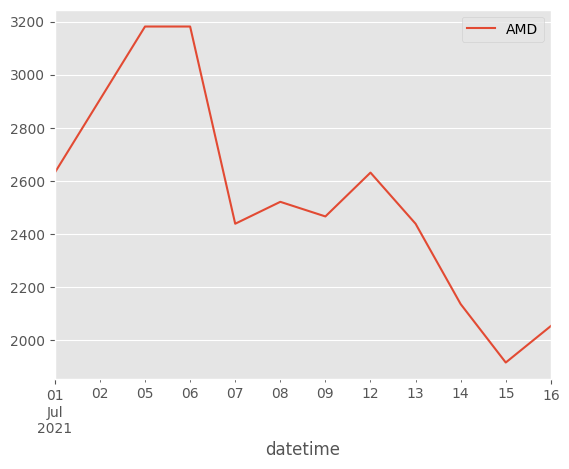

In [12]:
# evb_backtest.portfolio._equity.plot(y = 'COST'), evb_backtest.portfolio._equity.plot(y = 'AAPL'), evb_backtest.portfolio._equity.plot(y = 'NVDA')
# for col in evb_backtest.portfolio._equity.columns:
#     if col not in ['cash', 'Total']:
#         evb_backtest.portfolio._equity.plot(y = col)
#         plt.show()
evb_backtest.portfolio._equity.plot(y = tick)

In [13]:
evb_backtest.portfolio.plot_portfolio()

In [14]:
evb_backtest.portfolio.aggregate()

Start                                                    2021-07-01 00:00:00
End                                                      2021-07-16 00:00:00
Duration                                                    15 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    19324.07
Equity Peak [$]                                                 20451.600735
Return [%]                                                          -2.90195
Buy & Hold Return [%]                                              -7.212513
CAGR [%]                                                           -51.15849
Volatility Ann. [%]                                                24.410428
Sharpe Ratio                                                       -2.819375
Sortino Ratio                                                      -3.213905
Skew                                                               -1.114858

## ***ANALYZE POSITIONS***

In [15]:
create_object_from_id?
Calculate.attribution?

Signature:
Calculate.attribution(
    asset,
    ts_start=None,
    ts_end=None,
    ts_timeframe='day',
    ts_timewidth='1',
    method='GB',
    replace='partial',
    return_both_data=False,
    **kwargs,
)
Docstring:
Calculate attribution of option asset 

Parameter:
____________
ts_start (str | Datetime): Start date if timeseries
ts_end (str | Datetime): End date if timeseries  
ts_timewidth (int): Examples 1,2,3,4. The span over the timeframe
ts_timeframe (str): The timeframe for aggregation, eg: Minute, Hour, Day, Month, Week, Year
method (str): Available methods are 'GB' for Greek Based and 'RV' for Revaluation
replace (str): Available options are 'partial', 'close', 'default_fill'. Partial replaces only the missing data, Close uses close data to fill, default_fill uses the default fill for all data
return_both_data (bool): If True. Will return both the PnL Data and Full Data
return_all: specific to OptionStructure. If True, will return all the data for the long and short leg


In [16]:
trades['structure_object'] = trades.apply(lambda x: create_object_from_id(x['Positions'], date = x['ExitTime'].strftime('%Y-%m-%d')), axis=1)

In [17]:
trades[preferred_cols+['structure_object']]
focus_index = 0
focus_object = trades.iloc[focus_index].structure_object
quantity = trades.iloc[focus_index].Quantity
ticker = trades.iloc[focus_index].Ticker
cash_for_tick = w_map[ticker] * 20_000
focus_start, focus_end = trades.iloc[focus_index].EntryTime.strftime('%Y-%m-%d'), trades.iloc[focus_index].ExitTime.strftime('%Y-%m-%d')
with Context(end_date = focus_start):
    tick_on_start = Stock(ticker)
    spot = list(tick_on_start.spot(spot_type = 'chain_price').values())[0]

with Context(end_date = focus_end):
    tick_on_start = Stock(ticker)
    spot_end = list(tick_on_start.spot(spot_type = 'chain_price').values())[0]
    
focus_start, focus_end

('2021-07-01', '2021-07-16')

In [18]:
focus_object.Structure['long'][0].OptTick

'AMD20220617C115'

In [19]:
size_leverage = 4.5
eq_equivalent_size = (math.floor(cash_for_tick/spot)/100) * size_leverage
eq_equivalent_size

1.305

In [20]:
focus_object.greeks?

Signature:
focus_object.greeks(
    greek_type='greek',
    ts_start=None,
    ts_end=None,
    ts_timewidth=None,
    ts_timeframe=None,
    return_all=False,
)
Docstring:
The greeks method returns a timeseries dataframe for greeks based. Only available for BSM model

PARAMS
______
ts (Bool): True to return dataframe timeseries, false to return spot in a dict
ts_start (str|datetime): Start Date
ts_end (str|datetime): End Date
ts_timewidth (str|int): Steps in timeframe
ts_timeframe (str): Target timeframe for series 
greek_type (str): Type of greek to return. Default is 'greek'.
    'greek' returns all greek, while passing 'delta', 'gamma', 'theta', 'vega' returns only the specific greek
return_all (bool): True to return all from each leg, False to return only the aggregate greeks


RETURNS
_________
pd.DataFrame or dict
File:      ~/cloned_repos/QuantTools/trade/assets/OptionStructure.py
Type:      method

In [21]:
long_leg = focus_object.Structure['long'][0]
short_leg = focus_object.Structure['short'][0]

long_attribution = Calculate.attribution(
    asset = long_leg,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill',
    return_both_data = True
)

short_attribution = Calculate.attribution(
    asset = short_leg,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill',
    return_both_data = True
)


attribution_gb = Calculate.attribution(
    asset = focus_object,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'GB',
    replace = 'default_fill'
) 


attribution = Calculate.attribution(
    asset = focus_object,
    ts_start = focus_start,
    ts_end = focus_end,
    method = 'RV',
replace = 'default_fill'
)

vol_ts = focus_object.vol(
    ts = True,
    ts_start = focus_start,
    ts_end = focus_end
)

greeks = focus_object.greeks(
    ts_start = pd.to_datetime(focus_start) - BDay(1),
    ts_end = focus_end
)


ticker_ob = Stock(ticker)
spot_ts = ticker_ob.spot(ts = True,
                    ts_start= pd.to_datetime(focus_start) - BDay(1),
                    ts_end=focus_end,
                    spot_type = 'chain_price')

Exception in thread SaveDataProcess:
Traceback (most recent call last):
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/chiemelienwanisobi/cloned_repos/QuantTools/trade/assets/helpers/DataManagers.py", line 416, in __process_data
    processed_data =  Calc_Risks(data, timeAggType, self.symbol, end,self.exp, self.right, start, self.strike,)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chiemelienwanisobi/cloned_repos/FinanceDatabase/dbase/DataAPI/Organizers.py", line 122, in Calc_Risks
    data['Bi

ValueError: Neither `start` nor `end` can be NaT

In [319]:
long_greeks = long_leg.greeks(
    ts_start = focus_start,
    ts_end = focus_end,
)

short_greeks = short_leg.greeks(
    ts_start = focus_start,
    ts_end = focus_end,
)

In [320]:
# long_greeks.iloc[long_greeks.Midpoint_delta == 0] = np.nan
# short_greeks.iloc[short_greeks.Midpoint_delta == 0] = np.nan
# short_greeks.fillna(method = 'ffill', inplace = True)
# long_greeks.fillna(method = 'ffill', inplace = True)
# greeks = long_greeks - short_greeks

In [321]:
long_full_data = long_attribution[0].set_index('Datetime')
long_pnl = long_attribution[1]

short_full_data = short_attribution[0].set_index('Datetime')
short_pnl = short_attribution[1]

## Attribution Func Stock change & Querying Spot Change are the same
## Calculate.attribution calculation on option structure matches with individual option leg calc
if (long_full_data['Stock_Close_Change_Mark'] - spot_ts['close'].diff()).dropna().sum() == 0:
    print('Stock change & Querying Spot Change are the same on long')
else:
    print('Stock change & Querying Spot Change are not the same on long')


if (short_full_data['Stock_Close_Change_Mark'] - spot_ts['close'].diff()).dropna().sum() == 0:
    print('Stock change & Querying Spot Change are the same on short')
else:
    print('Stock change & Querying Spot Change are not the same on short')


if ((long_pnl - short_pnl) - attribution_gb)['Delta_PnL'].sum() == 0:
    print('PnL Attribution on Structure and Individual Legs match')
else:
    print('PnL Attribution on Structure and Individual Legs do not match')

## Greeks on Structure and Individual Legs match
if ((long_greeks - short_greeks) - greeks)['Midpoint_delta'].sum() == 0:
    print('Greeks on Structure and Individual Legs match')
else:
    print('Greeks on Structure and Individual Legs do not match')


if (((greeks['Midpoint_delta'] * 100) * spot_ts['close'].diff()) - ((greeks['Midpoint_delta'] * 100) * short_full_data['Stock_Close_Change_Mark'])).sum() == 0:
    print('Structure Delta * Spot_TS diff == Structure Delta * Stock_Close_Change_Mark')
else:
    print('Structure Delta * Spot_TS diff != Structure Delta * Stock_Close_Change_Mark')

long_leg_strike = spot/long_leg.K
short_leg_strike = spot/short_leg.K
long_leg_strike_end = spot_end/long_leg.K
short_leg_strike_end = spot_end/short_leg.K
print('Moneyness at Start: Long Leg Strike:', f"{long_leg_strike:.0%}", 'Short Leg Strike:', f"{short_leg_strike:.0%}")
print('Moneyness at End: Long Leg Strike:', f"{long_leg_strike_end:.0%}", 'Short Leg Strike:', f"{short_leg_strike_end:.0%}")

Stock change & Querying Spot Change are the same on long
Stock change & Querying Spot Change are the same on short
PnL Attribution on Structure and Individual Legs match
Greeks on Structure and Individual Legs match
Structure Delta * Spot_TS diff == Structure Delta * Stock_Close_Change_Mark
Moneyness at Start: Long Leg Strike: 90% Short Leg Strike: 88%
Moneyness at End: Long Leg Strike: 92% Short Leg Strike: 90%


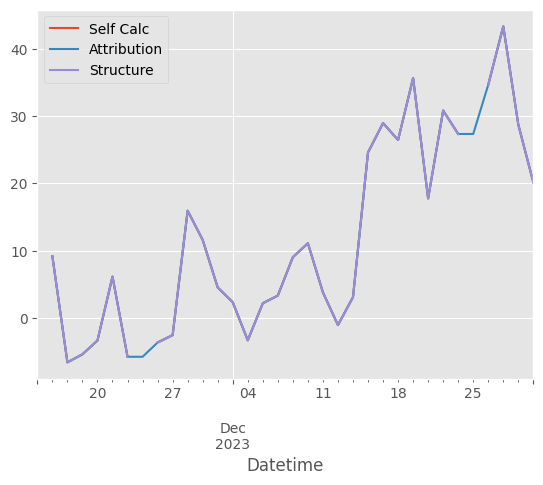

In [322]:
self_calc_pnl = ((long_full_data['Delta'] - short_full_data['Delta'])*100) * spot_ts['close'].diff()
self_calc_pnl.cumsum().plot(label = 'Self Calc'), attribution_gb['Delta_PnL'].cumsum().plot(label = 'Attribution'), (((long_full_data['Delta'] - short_full_data['Delta'])*100) * spot_ts['close'].diff()).cumsum().plot(label = 'Structure')
plt.legend()

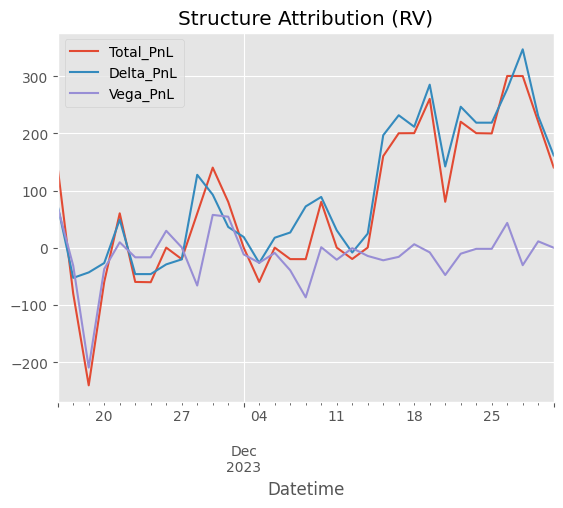

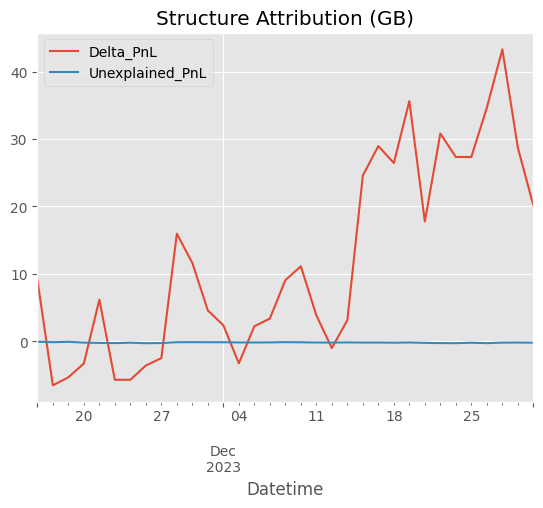

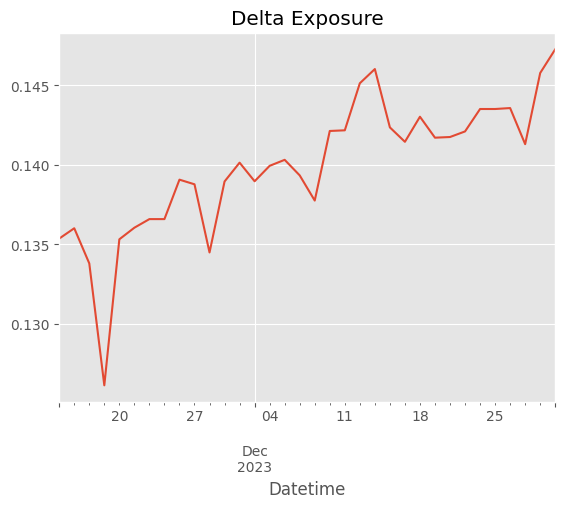

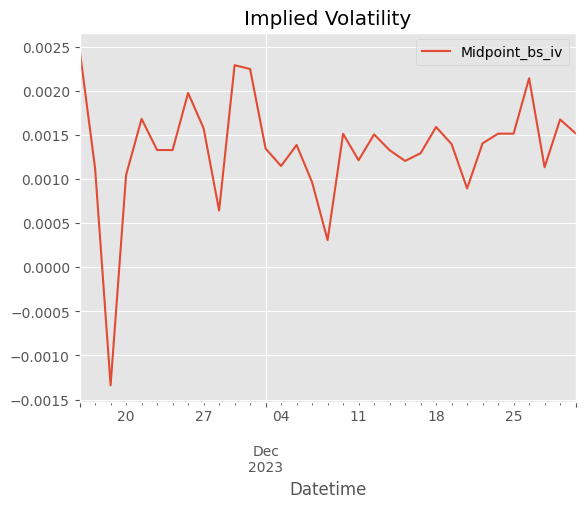

In [329]:
attribution['Gamma_Carry'] = attribution['Gamma_PnL'] + attribution['Theta_PnL']

(attribution * quantity).cumsum().plot(y = ['Total_PnL', 'Delta_PnL', 'Vega_PnL'], title = 'Structure Attribution (RV)')
plt.show()

(attribution_gb ).cumsum().plot(y = [ 'Delta_PnL', 'Unexplained_PnL'], title = 'Structure Attribution (GB)')
plt.show()


(greeks['Midpoint_delta'] *  quantity).plot(y = ['Midpoint_delta'], title = 'Delta Exposure')
plt.show()

vol_ts.plot(y = 'Midpoint_bs_iv', title = 'Implied Volatility')
plt.show()

In [324]:
delta = greeks['Midpoint_delta'].shift(1)
quantity_edit = pd.Series(index = delta.index)
booked_quantity = pd.Series(index = delta.index, data = [False]*len(delta)) ## Booked quantity is the quantity that has been booked for the day
q_change = pd.Series(index = delta.index, data = [0]*len(delta)) ## Quantity change for the day
## The plan is to simulate some sort of rebalance, where we want to keep delta within a certain range,
## We plan to achieve this by reducing quantity when delta is too high and increasing quantity when delta is too low
q = quantity
d_threshold = 0.6
d_threshold = eq_equivalent_size
print(f"Equivalent Expected Size: {eq_equivalent_size:.2f}")
## Start loop
for _delta, index in zip((delta), delta.index):
    day_delta = _delta * q
    if day_delta > d_threshold:
        while day_delta >d_threshold:
            q -= 1
            q_change.loc[index] += 1
            day_delta = _delta * q
        quantity_edit.loc[index] = q
        booked_quantity.loc[index] = True
    else:
        quantity_edit.loc[index] = q

    # print(q)
quantity_edit

Equivalent Expected Size: 0.36


Datetime
2023-11-14    8.0
2023-11-15    8.0
2023-11-16    8.0
2023-11-17    8.0
2023-11-20    8.0
2023-11-21    8.0
2023-11-22    8.0
2023-11-23    8.0
2023-11-24    8.0
2023-11-27    8.0
2023-11-28    8.0
2023-11-29    8.0
2023-11-30    8.0
2023-12-01    8.0
2023-12-04    8.0
2023-12-05    8.0
2023-12-06    8.0
2023-12-07    8.0
2023-12-08    8.0
2023-12-11    8.0
2023-12-12    8.0
2023-12-13    8.0
2023-12-14    8.0
2023-12-15    8.0
2023-12-18    8.0
2023-12-19    8.0
2023-12-20    8.0
2023-12-21    8.0
2023-12-22    8.0
2023-12-25    8.0
2023-12-26    8.0
2023-12-27    8.0
2023-12-28    8.0
2023-12-29    8.0
Freq: B, dtype: float64

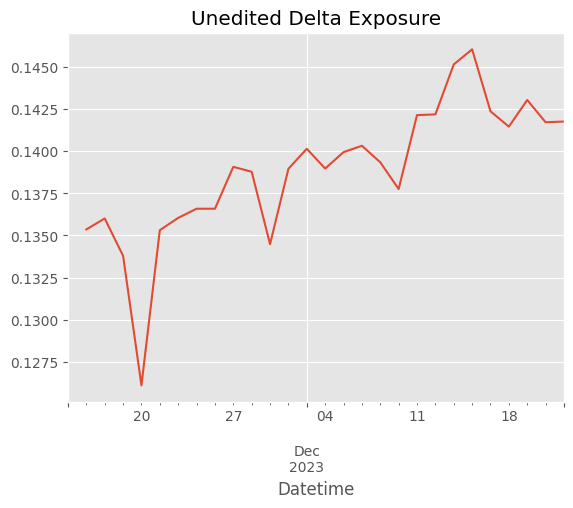

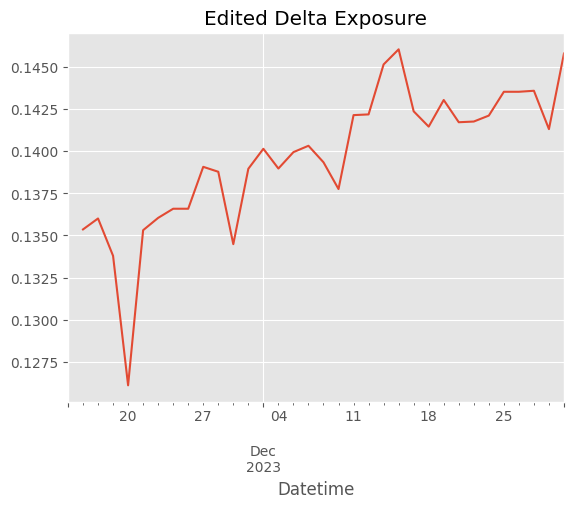

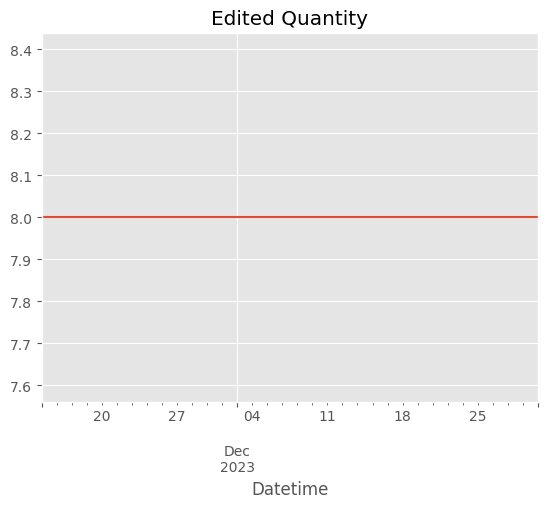

In [325]:
(delta[:-1] * quantity).iloc[:-5].plot(title = "Unedited Delta Exposure")
plt.show()
(delta * quantity_edit).plot(title = "Edited Delta Exposure")
plt.show()
quantity_edit.plot(title = "Edited Quantity")
plt.show()

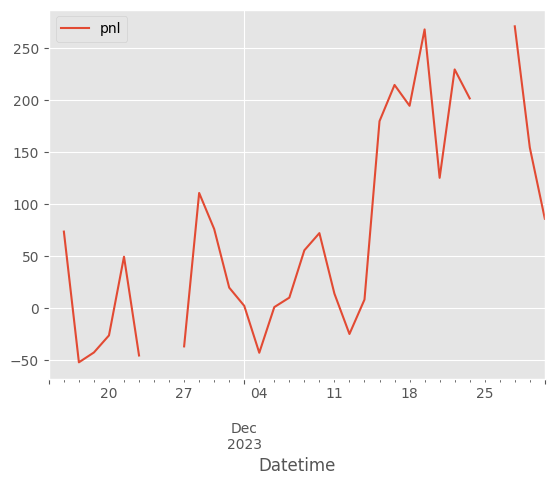

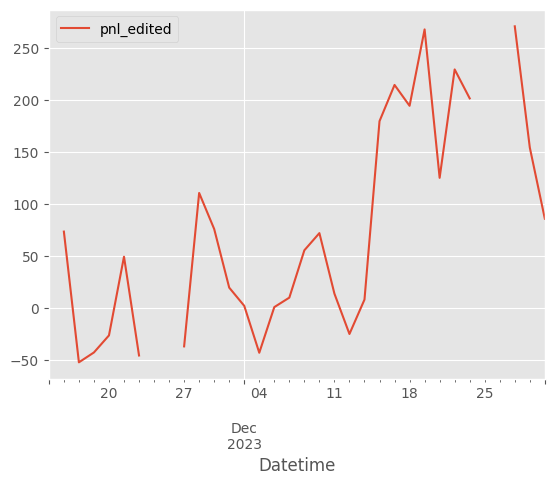

In [326]:
delta = greeks['Midpoint_delta'].shift(1)
quantity_ts = pd.Series([quantity]*len(delta), index = delta.index)
quantity_ts
delta_frame = delta.to_frame()
delta_frame['spot_close'] = spot_ts['close']
delta_frame['unedited_quantity'] = quantity
delta_frame['edited_quantity'] = quantity_edit
delta_frame['close_change'] = delta_frame['spot_close'] - delta_frame['spot_close'].shift(1)
delta_frame['edited_delta'] = (delta_frame['edited_quantity'] * delta_frame['Midpoint_delta']) * 100
delta_frame['unedited_delta'] = (delta_frame['unedited_quantity'] * delta_frame['Midpoint_delta']) * 100
delta_frame['pnl'] = delta_frame['unedited_delta'] * delta_frame['close_change']
delta_frame['pnl_edited'] = delta_frame['edited_delta'] * delta_frame['close_change']
# delta_frame['pnl'].cumsum().plot(y = 'undedited_quantity')
# delta_frame['pnl_edited'].cumsum().plot(y = 'edited_quantity')
# plt.legend()
# plt.show()
# delta_frame.plot(y = ['unedited_delta', 'edited_delta'])
delta_frame.cumsum().plot(y = ['pnl'])
plt.show()
delta_frame.cumsum().plot(y = ['pnl_edited'])
plt.show()

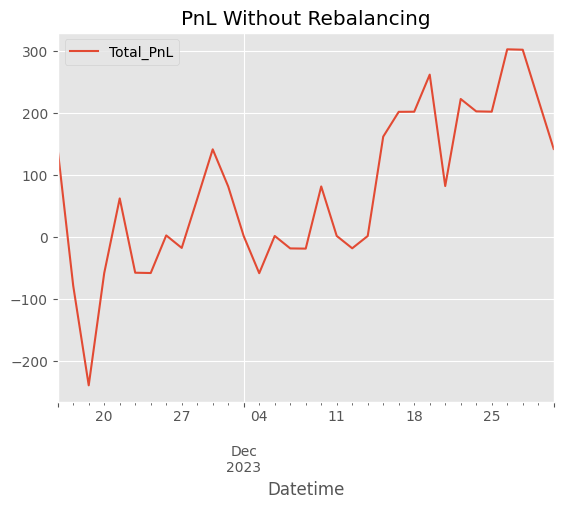

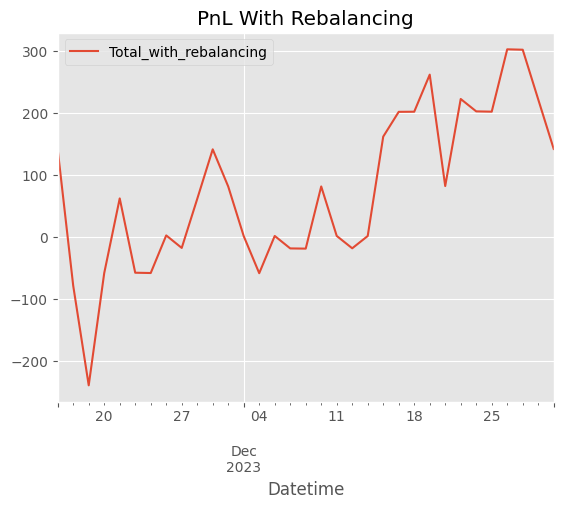

In [331]:
attribution_gb['booked_pnl'] = 0
attribution_gb['booked_delta'] = 0
for date in  booked_quantity[booked_quantity == True].index:
    profit = (attribution_gb.loc[:date, 'Total_PnL'].sum() * q_change.loc[date]) - (q_change.loc[date] * 1.3)
    delta_pnl = (attribution_gb.loc[date, 'Delta_PnL'] * q_change.loc[date])
    attribution_gb.loc[date, 'booked_pnl'] = profit
    attribution_gb.loc[date, 'booked_delta'] = delta_pnl
    print(f"Q Change {q_change.loc[date]} PnL {profit} on {date}")
attribution_gb['q2'] = quantity_edit
attribution_gb['Total_with_rebalancing'] = attribution_gb['Total_PnL'] * attribution_gb['q2'] + attribution_gb['booked_pnl']
attribution_gb['Delta_PnL With Rebalancing'] = attribution_gb['Delta_PnL'] * attribution_gb['q2'] + attribution_gb['booked_delta']
attribution_gb['Full_PnL_No_Rebalancing'] = attribution_gb['Total_PnL'] * quantity
(attribution_gb * quantity).cumsum().plot(y = 'Total_PnL', title = 'PnL Without Rebalancing')
plt.show()
(attribution_gb).cumsum().plot(y = 'Total_with_rebalancing', title = 'PnL With Rebalancing')
plt.show()

In [337]:
pd.options.display.max_columns = 100
attribution_gb.cumsum().tail(1) 

,Delta_PnL,Gamma_PnL,Theta_PnL,Vega_PnL,Volga_PnL,Vanna_PnL,Rho_PnL,Total_PnL,Unexplained_PnL,Actual_PnL,Price,booked_pnl,q2,Total_with_rebalancing,booked_delta,Delta_PnL With Rebalancing,Full_PnL_No_Rebalancing
Datetime,,,,,,,,,,,,,,,,,
2023-12-29,20.146776,-0.959664,-1.684245,0.190445,-0.093982,0.252768,-0.141502,17.710597,-0.210597,17.5,5992.5,0,264.0,141.684778,0,161.17421,141.684778


: 

In [294]:
f"{attribution_gb.cumsum().Total_with_rebalancing[-1]/cash_used_position: .2%}"

' 20.14%'

In [122]:
# tick, entry, exit = '&L:META20220916C380&S:META20220916C385	2021-11-16	2021-11-29'.split('\t')
# _, long, short = tick.split('&')
# long, short = long[2:], short[2:] 
# price_data = evb_backtest.portfolio.options_data[long] - evb_backtest.portfolio.options_data[short]
# price_data.plot(y = 'Midpoint')
# price_data[(price_data.index >=entry) & (price_data.index <= exit)]
# # price_data#[price_data.index.isin(['2022-01-04', '2022-01-21'])]

## ***RANDOMS***

In [123]:
# COST20240621C550
retrieve_eod_ohlc('COST',
                  '2024-01-15',
                  '2024-06-21',
                  'C',
                  '2023-07-03',
                  560.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/eod?end_date=20240115&root=COST&use_csv=true&exp=20240621&right=C&start_date=20230703&strike=560000


,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-03,43.23,43.23,43.23,43.23,1,48,42.10,10,45.15,43.625,42.625862
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-05,43.25,43.32,43.25,43.32,2,16,43.55,10,44.95,44.250,44.088462
2023-07-06,42.00,43.90,42.00,43.90,4,15,42.30,15,44.40,43.350,43.350000
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,0.00,0.00,0.00,0.00,0,16,118.25,7,120.70,119.475,118.995652
2024-01-09,0.00,0.00,0.00,0.00,0,21,121.75,31,124.90,123.325,123.627885
2024-01-10,0.00,0.00,0.00,0.00,0,6,125.20,7,132.05,128.625,128.888462


In [124]:
(1.235/1.950)-1

-0.3666666666666666

In [125]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long               short  \
datetime   symbol                                           
2023-01-19 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-20 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-23 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-24 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-25 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-26 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-27 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-30 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-01-31 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-01 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-02 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-03 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-06 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-07 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-08 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-09 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-10 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-13 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-14 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-15 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-16 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-17 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-20 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-21 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-22 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-23 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-24 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-27 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-02-28 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-03-01 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-03-02 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-03-03 NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
           NVDA    [NVDA20240119C255]  [NVDA20240119C265]   
2023-03

In [126]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function